# PCA with Poisonous Mushrooms

Radhika Mardikar


In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### PCA and fraction of total variance

Fraction of  1  components is  0.2972781014878153
Fraction of  2  components is  0.39901266670928076
Fraction of  3  components is  0.4696462310591405
Fraction of  4  components is  0.5083126945661669
Fraction of  5  components is  0.5451207376410584
Fraction of  10  components is  0.6726965620994348
Fraction of  20  components is  0.819678424424499
Fraction of  30  components is  0.9049617095676075
Fraction of  40  components is  0.9551231305614527
Fraction of  50  components is  0.9839706320061623



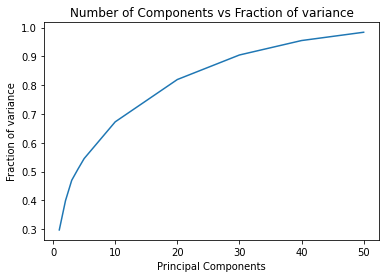

In [5]:
def varfrac():
    model = PCA()
    xtrained = model.fit(train_data)
    explain_var = model.explained_variance_ratio_.cumsum()
    
    ks = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    vars = []
    for k in ks:
      print('Fraction of ', k,' components is ', explain_var[k])
      vars.append(explain_var[k])
    print()
    plt.plot(ks, vars)
    plt.xlabel('Principal Components')
    plt.ylabel('Fraction of variance')
    plt.title('Number of Components vs Fraction of variance')
    plt.show()

varfrac()

###  PCA for visualization

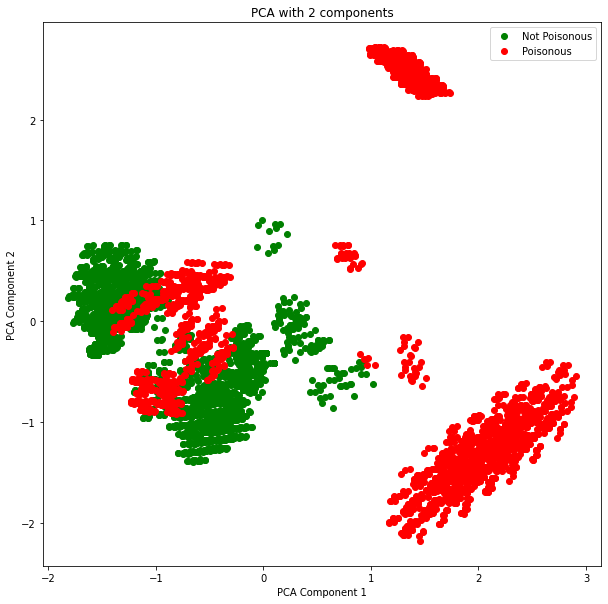

In [6]:
def pcaplot():   
  model = PCA(n_components = 2)
  xtrained = model.fit_transform(train_data)

  plt.figure(figsize=[10,10])
  plt.plot(xtrained[:,0][train_labels == 0], xtrained[:,1][train_labels == 0], 'go')
  plt.plot(xtrained[:,0][train_labels == 1], xtrained[:,1][train_labels == 1], 'ro')

  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.legend(['Not Poisonous', 'Poisonous'])
  plt.title('PCA with 2 components')

pcaplot()

###  Visualizing GMMs


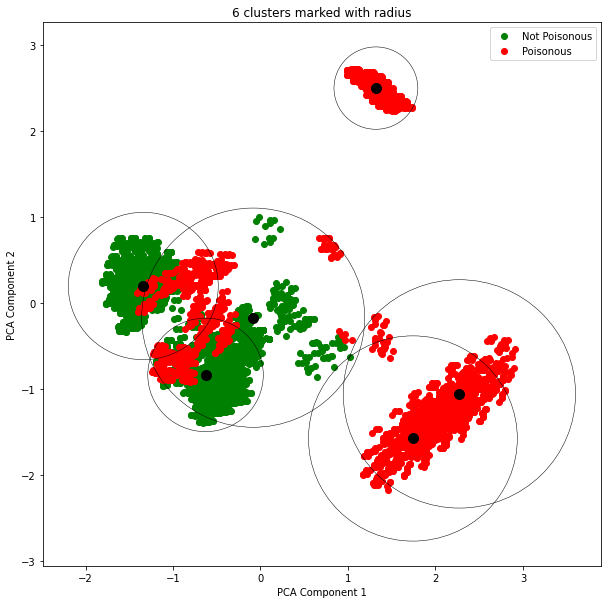

In [7]:
def gmmmaker():   
  pca = PCA(n_components = 2)
  xtrained = pca.fit_transform(train_data)


  model = KMeans(n_clusters=6)
  fittedx = model.fit_predict(xtrained)
  center = model.cluster_centers_


  clusters = {}
  for index, label in enumerate(fittedx):
    if label in clusters.keys():
      clusters[label].append(index)
    else:
      clusters[label] = [index]
 
  maxlist = {}
  for key in clusters.keys():
    max = 0
    for i in clusters[key]:
      radius = np.linalg.norm(np.subtract(xtrained[i], center[key]))
      if radius > max:
        max = radius
    maxlist[key] = max
  
  
  plt.figure(figsize=[10,10])
 

  
  
  ax=plt.gca()
  for j in maxlist.keys():
    circle = plt.Circle((center[j]), radius = maxlist[j], fill = False, color = 'black', linewidth = 0.5, zorder = 10)
    ax.add_patch(circle)
    ax.scatter(center[j, 0], center[j, 1], color = 'black', s = 100, zorder = 10)
  
  plt.plot(xtrained[:,0][train_labels == 0], xtrained[:,1][train_labels == 0], 'go')
  plt.plot(xtrained[:,0][train_labels == 1], xtrained[:,1][train_labels == 1], 'ro')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.legend(['Not Poisonous', 'Poisonous'])
  plt.title('6 clusters marked with radius')

gmmmaker()

### Understanding GMMs with Density Plots

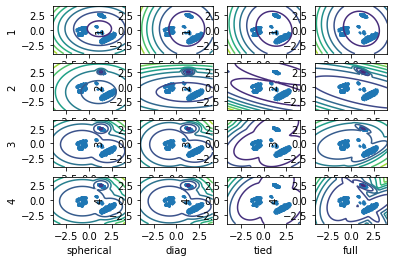

In [17]:
def densityplot():
    model = PCA(n_components = 2)
    xtrained = model.fit_transform(train_data)
    poison = xtrained[train_labels == 1]
    covars = ['spherical', 'diag', 'tied', 'full']
    comp = [1,2,3,4]
    count = 0
    plt.figure()

    for i in comp:
      for j in covars:
        mod = GaussianMixture(n_components=i, covariance_type=j, random_state=12345).fit(poison)
        count += 1
        x = np.linspace(-4.0, 4.0)
        y = np.linspace(-4.0, 4.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -mod.score_samples(XX)
        Z = Z.reshape(X.shape)

        
        plt.subplot(4, 4, count)
        CS = plt.contour(X, Y, Z)
        

        plt.xlabel(j)
        plt.ylabel(i)
        plt.scatter(poison[:,0], poison[:,1], 0.8)
      
    
        

densityplot()

Tied means that all components share the same covariance matrix so you are more likely to see a more general shape instead of multiple little ones. In full, each component has its own covariance matrix which means that each component can take its own shape in any direction. We can see that with full there is more "jutting" out rather than smoother ovals/circles. 

### Using Unsupervised models for classification

In [12]:
def unsup():  
  model = PCA(n_components = 2)
  xtrained = model.fit_transform(train_data)
  xtest = model.transform(test_data)

  df = pd.DataFrame()
  df['pc1'] = xtrained[:,0]
  df['pc2'] = xtrained[:,1]
  df['label'] = train_labels

  nonpoison = df[df['label'] == 0]
  poison = df[df['label'] == 1]

  gmm_poison = GaussianMixture(n_components=4, covariance_type='full', random_state = 12345)
  gmm_poison.fit(poison[['pc1','pc2']])
  gmm_nonpoison = GaussianMixture(n_components=4, covariance_type='full', random_state = 12345)
  gmm_nonpoison.fit(nonpoison[['pc1','pc2']])
  
  test = pd.DataFrame()
  test['predpoison'] = gmm_poison.score_samples(xtest)
  test['prednonpoison'] = gmm_nonpoison.score_samples(xtest)
  test['label'] = test_labels
  test['finalpred'] = (test['predpoison']>test['prednonpoison']).astype(int)
  correct = sum(test.apply(lambda x: 1 if x['finalpred'] == x['label'] else 0 , axis=1))
 
  
  accuracy = correct/(len(test_labels))
  print("Accuracy of prediction on test data is ", accuracy)
  


unsup()

Accuracy of prediction on test data is  0.9501779359430605


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  "X does not have valid feature names, but"


### Understanding the GMM parameters

Accuracy is:  0.9688612099644128  PCA component number:  5  GMM component number:  4  Covariance type:  spherical  Parameter count:  48


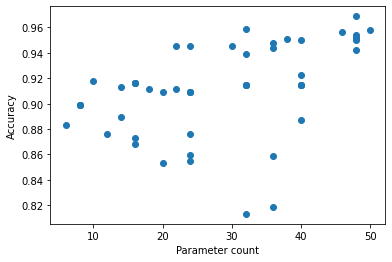

In [32]:
from matplotlib.lines import Line2D

def params():
  pcacomponent = [1, 2, 3, 4, 5]
  gmmcomponent = [2,4,6,8,10]
  covars = ['spherical', 'diag', 'full', 'tied']
  config = []
  accuracy = 0
  paramcount = []
  accuracylist = []

  for pcacomp in pcacomponent:
    model = PCA(n_components = pcacomp)
    xtrained = model.fit_transform(train_data)
    xtest = model.transform(test_data)

    normal = xtrained[train_labels == 0]
    poison = xtrained[train_labels == 1]
    config = {}
    for gmmcomp in gmmcomponent:
      for var in covars:
        gmm_poison = GaussianMixture(n_components=gmmcomp, covariance_type=var, random_state = 12345)
        gmm_poison.fit(poison)
        gmm_nonpoison = GaussianMixture(n_components=gmmcomp, covariance_type=var, random_state = 12345)
        gmm_nonpoison.fit(normal)
        parameter = 0
        if var == 'spherical':
          parameter = (pcacomp*gmmcomp + gmmcomp) * 2
        elif var == 'diag':
          parameter = (pcacomp*gmmcomp + pcacomp * gmmcomp) * 2
        elif var == 'full':
          parameter = (pcacomp*gmmcomp + pcacomp * (pcacomp + 1)/ 2 * gmmcomp) * 2
        else:
          parameter = (pcacomp*gmmcomp + pcacomp * (pcacomp + 1)/ 2) * 2
        if parameter <= 50:
          correct = 0
          paramcount.append(parameter)

          for i in range(len(test_labels)):
            if (gmm_poison.score([xtest[i]]) < gmm_nonpoison.score([xtest[i]])) and (test_labels[i] == 0):
              correct += 1
            if (gmm_poison.score([xtest[i]]) > gmm_nonpoison.score([xtest[i]])) and (test_labels[i] == 1):
              correct += 1
          temp = correct/len(test_labels)
          accuracylist.append(temp)
          if temp > accuracy:
            accuracy = temp
            config[accuracy] = [ pcacomp,  gmmcomp, var, parameter]
        
  max = 0
  for key in config.keys():
    if key > max:
      max = key

  print('Accuracy is: ', max, ' PCA component number: ', config[max][0], ' GMM component number: ', config[max][1], ' Covariance type: ', config[max][2], ' Parameter count: ', config[max][3])
  plt.scatter(paramcount, accuracylist)
  plt.xlabel("Parameter count")
  plt.ylabel("Accuracy")

params()